# Overview
Diversity has been an important topic, in academics, work and daily life. Therefore, it is important to understand if there are potential issues under such a diverse enviornment, such as unfairness or conflicts. In this notebook, we are going to study diversity from an employee dataset, analyzing patterns and structures of the company, and trying to come up with a predictive model predicting salary levels.

## 1. Data Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
hierarchy = pd.read_csv("company_hierarchy.csv")
hierarchy.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [3]:
employee = pd.read_csv("employee.csv")
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [4]:
hierarchy.isnull().mean() #missing boss_id, probably CEO

employee_id    0.0000
boss_id        0.0001
dept           0.0000
dtype: float64

In [5]:
hierarchy[hierarchy["boss_id"].isna()]

,employee_id,boss_id,dept
2427,61554,NaN,CEO


In [6]:
employee.isnull().mean()

employee_id       0.0
signing_bonus     0.0
salary            0.0
degree_level      0.0
sex               0.0
yrs_experience    0.0
dtype: float64

In [7]:
#How many managers are there? 
ct = hierarchy["boss_id"][~hierarchy["boss_id"].isna()].value_counts().to_frame().reset_index()
ct = ct.rename(columns={"index":"boss_id","boss_id":"num_direct_report"})
ct

,boss_id,num_direct_report
0,168905.0,23
1,159098.0,22
2,51121.0,22
3,8711.0,22
4,101484.0,21
...,...,...
994,71499.0,2
995,131950.0,1
996,157530.0,1
997,54963.0,1


There are 999 employees who manage people (boss). The above counts record the number of times they appear as someone's boss, which is the number of employees that directly report to them. We can use this information to calculate the number of employees someone manages.

In [8]:
hierarchy[hierarchy["boss_id"] ==61554 ]

,employee_id,boss_id,dept
1009,110464,61554.0,marketing
1310,11277,61554.0,sales
2778,51535,61554.0,engineering
9640,93708,61554.0,HR


In [9]:
#changing data type for consistency
hierarchy.loc[:,"employee_id"] = hierarchy["employee_id"].astype(float)
employee.loc[:,"employee_id"] = employee["employee_id"].astype(float)

In [10]:
num_emp = []
for i in range(ct.shape[0]):
    start = ct["num_direct_report"].iloc[i]
    boss_id = ct["boss_id"].iloc[i]
    #direct report
    hierarchy_i = hierarchy[hierarchy["boss_id"] == boss_id]
    #employees who directly report to boss_id
    emp = hierarchy_i["employee_id"]
    #keep looping if anyone in emp manages other employees
    while any(emp.isin(ct["boss_id"])):
        #employee ids that are bosses
        emps_that_are_bosses = emp[emp.isin(ct["boss_id"])]
        #add number of direct report for each of those employee ids
        start += sum(ct[ct["boss_id"].isin(emps_that_are_bosses)]["num_direct_report"])
        #re-assign employees ids to the ones in the next level (those who report to employee ids that are bosses )
        emp = hierarchy[hierarchy["boss_id"].isin(emps_that_are_bosses)]["employee_id"]
    num_emp.append(start)

In [11]:
ct.loc[:,"total_report"] = num_emp
ct.head()

,boss_id,num_direct_report,total_report
0,168905.0,23,23
1,159098.0,22,22
2,51121.0,22,22
3,8711.0,22,22
4,101484.0,21,21


In [12]:
hierarchy.loc[:,"total_report"] = 0
hierarchy.loc[hierarchy["employee_id"].isin(ct["boss_id"]),"total_report"] = hierarchy[hierarchy["employee_id"].isin(
    ct["boss_id"])]["employee_id"].apply(lambda x: ct[ct["boss_id"]==x]["total_report"].iloc[0])

In [13]:
#total report is the number of employees a person manages both directly and indirectly
hierarchy.head(10)

,employee_id,boss_id,dept,total_report
0,46456.0,175361.0,sales,0
1,104708.0,29733.0,HR,0
2,120853.0,41991.0,sales,0
3,142630.0,171266.0,HR,16
4,72711.0,198240.0,sales,0
5,61704.0,53109.0,sales,0
6,153072.0,67178.0,HR,0
7,58903.0,150290.0,HR,0
8,166034.0,116750.0,engineering,0
9,54819.0,182038.0,sales,0


In [14]:
#CEO manages all employees
hierarchy[hierarchy["dept"]=="CEO"]

,employee_id,boss_id,dept,total_report
2427,61554.0,NaN,CEO,9999


## EDA
- In order to visualize relationships among variables, including number of reports, merging is necessary.
- It is interesting to find out if there are any patterns among salary, bonus, sex, education level, experiences and employees counts.

In [15]:
df = pd.merge(hierarchy, employee, on = "employee_id")
df.head()

,employee_id,boss_id,dept,total_report,signing_bonus,salary,degree_level,sex,yrs_experience
0,46456.0,175361.0,sales,0,0,213000.0,Bachelor,M,5
1,104708.0,29733.0,HR,0,0,79000.0,Bachelor,F,3
2,120853.0,41991.0,sales,0,0,199000.0,High_School,M,5
3,142630.0,171266.0,HR,16,0,143000.0,PhD,F,13
4,72711.0,198240.0,sales,0,0,235000.0,Master,M,1


<AxesSubplot:xlabel='salary'>

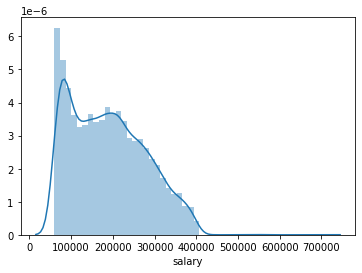

In [16]:
#distribution of salary, a little bit right skewed
sns.distplot(df["salary"])

<BarContainer object of 2 artists>

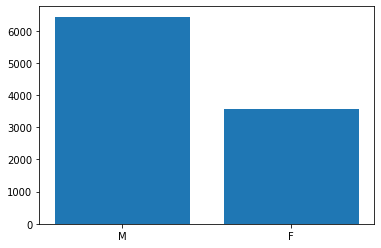

In [17]:
plt.bar(df.sex.value_counts().index,df.sex.value_counts())
#there are almost twice as many male employees as female employees

<AxesSubplot:xlabel='sex', ylabel='salary'>

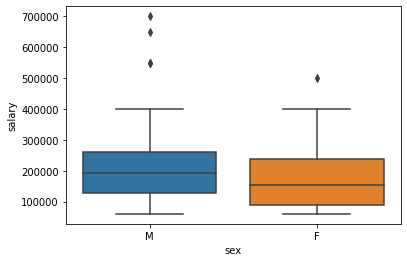

In [18]:
#salary vs. sex: males have a higher median salary than females
sns.boxplot("sex","salary",data=df)

<AxesSubplot:xlabel='sex', ylabel='total_report'>

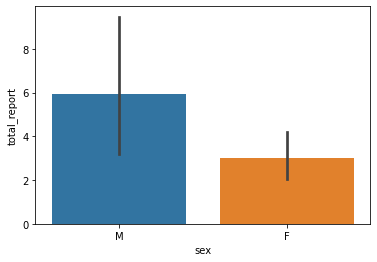

In [19]:
#average report count vs. sex: males have higher average of number of reports, also higher variances
#outliers (extremely high report counts) almost all of them belong to male employees
sns.barplot("sex","total_report",data=df)

<AxesSubplot:xlabel='yrs_experience', ylabel='salary'>

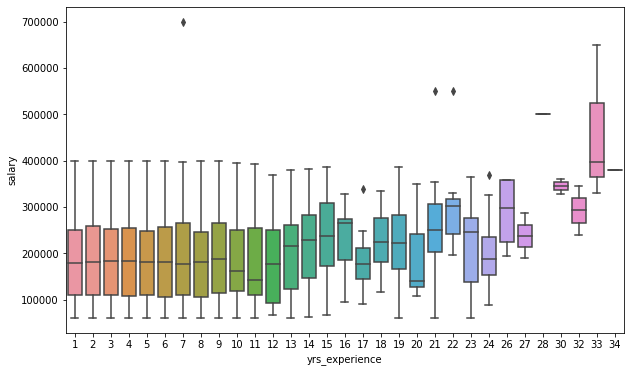

In [20]:
#years of experiences vs salary
plt.figure(figsize=(10,6))
sns.boxplot("yrs_experience","salary",data=df)

For employees with experiences less than 10 years, they have similar median salary and variances, and for employees with more than 10 years of experiences, more experiences does not equal to higher salary in some cases, this is probably due to other factors such as department and education. 

<AxesSubplot:xlabel='yrs_experience', ylabel='count'>

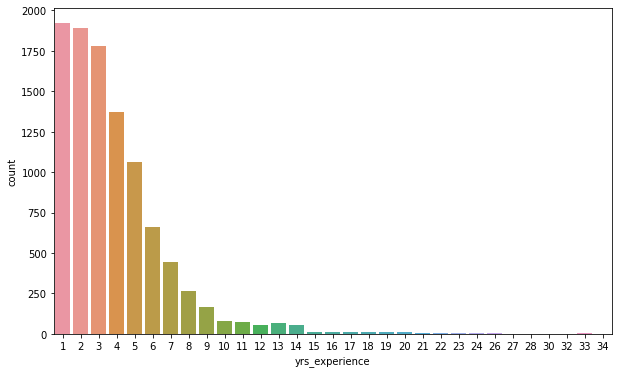

In [21]:
#years of experiences counts
plt.figure(figsize=(10,6))
sns.countplot("yrs_experience",data=df)

<AxesSubplot:xlabel='yrs_experience', ylabel='signing_bonus'>

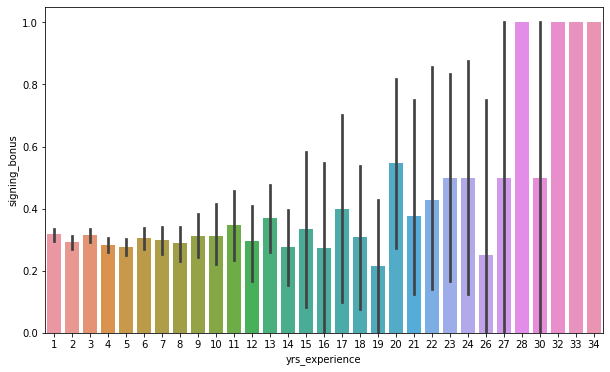

In [22]:
#years of experiences vs sign on bonus
plt.figure(figsize=(10,6))
sns.barplot("yrs_experience","signing_bonus",data=df)

Differences in average signing bonus began to show up for employees with more than 10 years experiences, and significantly higher for employees > 20 years experiences, but there are exceptions as well, we will tie these observations with department and education. For those employees with >= 32 years experiences, signing bonus is fixed and highest. One other thing to notice is that the majority of the employees are within the <= 5 years category, which makes their variances smaller and might be more informative.

<AxesSubplot:xlabel='degree_level', ylabel='salary'>

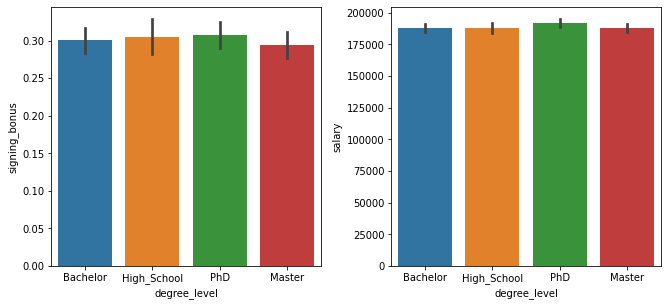

In [23]:
#years of experiences vs sign on bonus
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.tight_layout(pad=4.0)
sns.barplot("degree_level","signing_bonus",data=df,ax=ax[0])
sns.barplot("degree_level","salary",data=df,ax=ax[1])

<AxesSubplot:xlabel='degree_level', ylabel='count'>

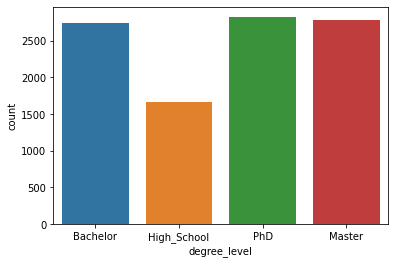

In [24]:
sns.countplot("degree_level", data=df)

The only consistent pattern seems to be that PhD students always have highest average salary and signing bonus. Bachelor and Mater students even have lower average signing bonus than high school graduates, although high school graduates have larger variances and there are much fewer high school graduates in the company so they might not be that representative.

<AxesSubplot:xlabel='dept', ylabel='salary'>

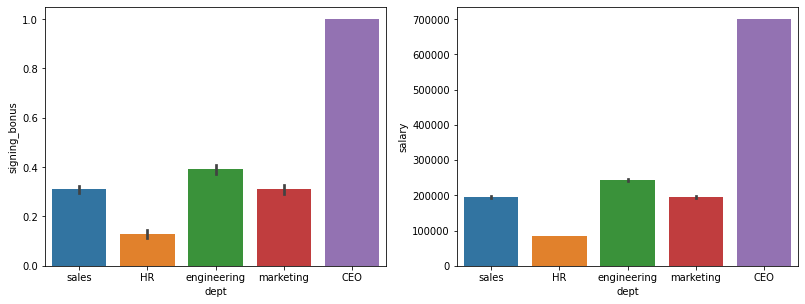

In [25]:
#years of experiences vs sign on bonus
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,5))
fig.tight_layout(pad=4.0)
sns.barplot("dept","signing_bonus",data=df,ax=ax[0])
sns.barplot("dept","salary",data=df,ax=ax[1])

Patterns are consistent across departments, besides CEO, engineering department has the highest average salary and signing bonus, HR department has the lowest averages. Sales and marketing departments have similar salary and bonus.

## 3. Linear Modeling
- Since we want a general understanding of salary, we have to take out CEO's data because it can be significantly different, no matter salary or other characteristics like department, report counts, and years of experiences.
- We can take a look at the correlations among numeric variables to identify the existence of high correlation.
- We can also perform contingency tables among categorical variables to test for homogeneity.
- We need to transform the response variable since the previous histogram shows that it's skewed.

In [26]:
#treat CEO as an outlier, remove it
final_df = df[df["dept"]!="CEO"]

<AxesSubplot:>

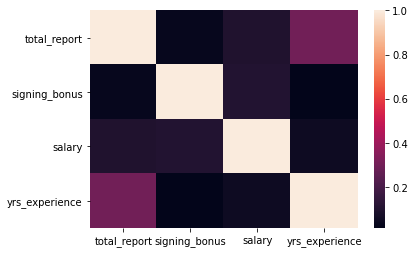

In [29]:
#correlation matrix for numeric variables
num_df = final_df[["total_report","signing_bonus","salary","degree_level","yrs_experience"]]
sns.heatmap(num_df.corr())

No high correlations exist based on the heatmap, they are positively correlated but not significant, we will include all of them in the model.

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [48]:
X = pd.get_dummies(final_df.drop(["employee_id","boss_id","salary"],axis=1),drop_first=True)
X.head()

,total_report,signing_bonus,yrs_experience,dept_engineering,dept_marketing,dept_sales,degree_level_High_School,degree_level_Master,degree_level_PhD,sex_M
0,0,0,5,0,0,1,0,0,0,1
1,0,0,3,0,0,0,0,0,0,0
2,0,0,5,0,0,1,1,0,0,1
3,16,0,13,0,0,0,0,0,1,0
4,0,0,1,0,0,1,0,1,0,1


<AxesSubplot:xlabel='salary'>

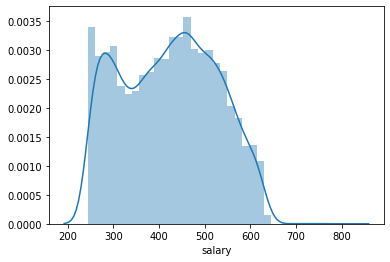

In [42]:
sns.distplot(np.sqrt(final_df["salary"]))

In [57]:
#using square root of salary
y = np.sqrt(final_df["salary"])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
mod = LinearRegression()
mod.fit(X_train, y_train)

LinearRegression()

In [58]:
#visualize the coefficients summary
import statsmodels.api as sm
from scipy import stats
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     503.0
Date:                Sun, 10 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:16:27   Log-Likelihood:                -46510.
No. Observations:                7999   AIC:                         9.304e+04
Df Residuals:                    7988   BIC:                         9.312e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      284.3908      2.998     94.870      0.000     278.515     290.267
total_report                 0.2481      0.037      6.731      0.000       0.176       0.320
signing_bonus                0.2472      2.012      0.123      0.902      -3.697       4.192
yrs_experience               0.7445      0.325      2.288      0.022       0.107       1.382
dept_engineering           194.5324      2.960     65.725      0.000     188.730     200.334
dept_marketing             144.9600      3.066     47.287      0.000     138.951     150.969
dept_sales                 145.3362      2.751     52.826      0.000     139.943     150.729
degree_level_High_School     0.1815      2.828      0.064      0.949      -5.361       5.724
degree_level_Master          0.5660      2.442      0.232      0.817      -4.220       5.352
degree_level_PhD             2.2049      2.443      0.903      0.367      -2.583       6.993
sex_M                       -1.1934      1.971     -0.606      0.545      -5.056       2.669
==============================================================================
Omnibus:                      100.864   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.173
Skew:                          -0.250   Prob(JB):                     2.92e-22
Kurtosis:                       2.780   Cond. No.                         146.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Linear regression does not perform very well, let's try a non-parametric method, random forest regression.

In [64]:
from sklearn.ensemble import RandomForestRegressor

In [87]:
rf = RandomForestRegressor(n_estimators=300,max_depth=5)

In [88]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=300)

In [89]:
rf.score(X_test, y_test)

0.38876225889982596

Text(0.5, 0, 'Relative Importance')

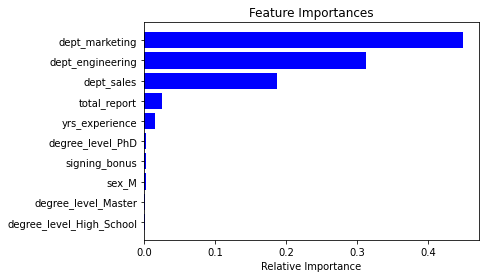

In [90]:
#No huge improvement on scores, but we can take a look at feature importance
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')


Besides department playing a significant role in determining salary level, total number of employees reporting and years of experiences are more significant than other factors such as sex and education.

These two methods did not give decent scores, however, there are other more holistic approaches not tried, one of them will be gradient boosting, which were used in this [wonderful notebook](https://github.com/JifuZhao/DS-Take-Home/blob/master/15.%20Diversity%20in%20the%20Workplace.ipynb).